In [4]:
import pandas as pd 
import numpy as np 
import psycopg2
import os 
from dotenv import load_dotenv
import seaborn as sns 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [5]:
def create_connection():
    load_dotenv()
    DATABASE = os.getenv("DATABASE")
    HOST = os.getenv("HOST")
    USER = os.getenv("USER")
    PASSWORD = os.getenv("PASSWORD")
    PORT = os.getenv("PORT")
    connection = psycopg2.connect(
        host=HOST, database=DATABASE, user=USER, password=PASSWORD
    )
    return connection

In [6]:
USER_ID = 19

## Extraction des données liés aux sport_rows

In [8]:
sql =   """
            -- Usefull to get all the data for the data visualisation 

SELECT 
    sport_rows.date_seance,
    sport_rows.sport, 
    sport_rows.exercice, 
    sport_rows.duree,
    NULL AS seance, 
    NULL AS poid,
    NULL AS nombre_repetition
FROM 
    sport_rows
WHERE 
    sport_rows.user_id = %s

UNION ALL 

SELECT 
    musculation_rows.date_seance,
    musculation_rows.sport as sport, 
    musculation_rows.exercice, 
    NULL AS duree,
    musculation_rows.seance,
    musculation_rows.poid,
    musculation_rows.nombre_repetition
FROM 
    musculation_rows
WHERE 
    musculation_rows.user_id = %s;
        """



In [9]:
def import_all_data(user):
    try:
        connection = create_connection()
        cursor = connection.cursor()
        cursor.execute(sql, (user, user))
        data = cursor.fetchall()
        columns = [
            "date",
            "sport",
            "exercice",
            "duree",
            "seance",
            "poid",
            "nombre_repetition",
        ]
        df_sport = pd.DataFrame(data, columns=columns)
        return df_sport

    except (Exception, psycopg2.Error) as error:
        print(f"Error while fetching data: {error}")
        return None, None
    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

In [10]:
    all_datas = import_all_data(USER_ID)


Error while fetching data: [Errno 2] No such file or directory: './sql/select_all_datas_for_user.sql'


In [6]:
df_sport_row = pd.DataFrame(data, columns=["date_seance","sport","exercice","duree","commentaire","id","user_id"])
df_sport_row.head()

,date_seance,sport,exercice,duree,commentaire,id,user_id
0,2024-02-24,Cardio,Vélo Elliptique,30.0,None,26,19
1,2024-02-24,Cardio,Cross Trainning,30.0,None,27,19
2,2024-02-24,Cardio,Tennis,60.0,None,28,19
3,2024-02-03,Cardio,Cross Trainning,NaN,20 pompes \n20 ballons mur en équilibres \n12 ...,95,19
4,2024-04-03,Cardio,Tennis,60.0,None,143,19



## Extraction des données liés aux musculation_rows

In [7]:
connection = create_connection()
cursor = connection.cursor()
sql =   """
            SELECT * FROM musculation_rows
            WHERE user_id = %s
        """
cursor.execute(sql, (USER_ID,))
data = cursor.fetchall()


In [8]:
df_musculation_row = pd.DataFrame(data, columns=["date_seance","seance","exercice","poid","nombre_repetition","commentaires","user_id"])
df_musculation_row.head()

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id
0,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
1,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
2,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19
3,2024-02-19,Pectoraux,Développé Couché,50.0,10.0,None,19
4,2024-02-19,Pectoraux,Développé Couché,50.0,9.0,None,19


In [9]:
df_musculation_row.shape

(1232, 7)

In [10]:
df_sport_row.shape

(38, 7)

In [11]:
connection = create_connection()
cursor = connection.cursor()
sql =   """
            SELECT * FROM cross_trainning_rows
            WHERE user_id = %s
        """
cursor.execute(sql, (USER_ID,))
data = cursor.fetchall()


In [12]:
df__cross_trainning_rows = pd.DataFrame(data, columns=["id","user_id","cross_trainning_serie_id","number","nombre_repetition","commentaires","user_id"])
df__cross_trainning_rows.head()

,id,user_id,cross_trainning_serie_id,number,nombre_repetition,commentaires,user_id


In [13]:
df_musculation_row.columns

Index(['date_seance', 'seance', 'exercice', 'poid', 'nombre_repetition',
       'commentaires', 'user_id'],
      dtype='object')

In [14]:
df_sport_row.columns

Index(['date_seance', 'sport', 'exercice', 'duree', 'commentaire', 'id',
       'user_id'],
      dtype='object')

In [15]:
df_all_sport = pd.concat([df_musculation_row,df_sport_row])

In [16]:
df_all_sport

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id,sport,duree,commentaire,id
0,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
1,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
2,2024-02-19,Pectoraux,Développé Couché,60.0,6.0,None,19,NaN,NaN,NaN,NaN
3,2024-02-19,Pectoraux,Développé Couché,50.0,10.0,None,19,NaN,NaN,NaN,NaN
4,2024-02-19,Pectoraux,Développé Couché,50.0,9.0,None,19,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33,2024-06-29,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,992.0
34,2024-06-30,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,993.0
35,2024-07-01,NaN,Stepper,NaN,NaN,NaN,19,Cardio,NaN,None,1012.0
36,2024-07-02,NaN,Tennis,NaN,NaN,NaN,19,Cardio,60.0,None,1026.0


## PLot with time value 

In [17]:
def create_empty_timeserie(time_analyse:str)->pd.Series:
    today_date = datetime.today().date()
    if time_analyse == "week":
        end_date = today_date - timedelta(weeks=1)
    elif time_analyse == "month":
        end_date = today_date - timedelta(days=30)
    elif time_analyse == "year":
        end_date = today_date - timedelta(days=365)
    else:
        raise ValueError("time_analyse must be 'week', 'month', or 'year'")
    
    return pd.date_range(start=end_date, end=today_date)

In [18]:
def filter_by_time_period(df_all_sport: pd.DataFrame, time_analyse: str):
    try: 
        df_all_sport["date_seance"] = pd.to_datetime(df_all_sport["date_seance"])
    except: 
        print("donnée date_seance déjà transformée")

    date_series = create_empty_timeserie(time_analyse)
    df_time_period = df_all_sport[
        (df_all_sport["date_seance"] >= date_series.min()) & 
        (df_all_sport["date_seance"] <= date_series.max())
    ]
    return df_time_period

In [19]:
df = filter_by_time_period(df_all_sport, "month")
df.head()

,date_seance,seance,exercice,poid,nombre_repetition,commentaires,user_id,sport,duree,commentaire,id
158,2024-08-03,Bras,Triceps à la Poulie,36.0,12.0,None,19,NaN,NaN,NaN,NaN
159,2024-08-03,Bras,Triceps à la Poulie,41.0,12.0,None,19,NaN,NaN,NaN,NaN
160,2024-08-03,Bras,Triceps à la Poulie,25.3,12.0,None,19,NaN,NaN,NaN,NaN
161,2024-08-03,Bras,Triceps à la Poulie,25.3,11.0,None,19,NaN,NaN,NaN,NaN
162,2024-08-03,Bras,Triceps à la Poulie,25.3,11.0,None,19,NaN,NaN,NaN,NaN


In [20]:

timeseries = create_empty_timeserie(time_analyse="month")
df_timeseries = pd.DataFrame(timeseries, columns=['date'])
df_timeseries['did_sport_this_day'] = df_timeseries['date'].apply(lambda x: 1 if x in df['date_seance'].values else 0)
print(df_timeseries.head())

        date  did_sport_this_day
0 2024-08-03                   1
1 2024-08-04                   1
2 2024-08-05                   0
3 2024-08-06                   0
4 2024-08-07                   0


In [21]:
df_timeseries["did_sport_this_day"].value_counts()

did_sport_this_day
0    29
1     2
Name: count, dtype: int64

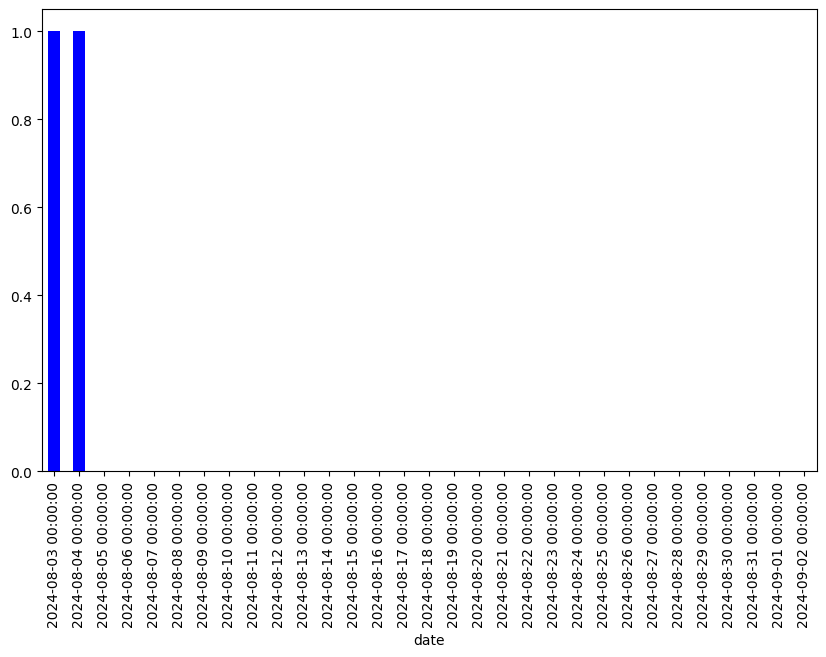

In [22]:
ax = df_timeseries.plot(
    x='date', 
    y='did_sport_this_day', 
    kind='bar', 
    figsize=(10, 6), 
    color='blue', 
    legend=False
)

In [23]:
def get_numerical_value(df_time_period:pd.DataFrame):
    number_of_day = df_time_period["date_seance"].ncount()
    number_of_exercice = df_time_period.groupby("date_seance")
    return number_of_day



In [24]:
df.exercice.nunique()

7

In [25]:
number_of_exercice = df.groupby("exercice").agg("count")
number_of_diferents_exercices = df["exercice"].nunique()
number_of_diferents_exercices

7

In [26]:
df["exercice"].unique()

array(['Triceps à la Poulie', 'Triceps à la Poulie Inversée',
       'Biceps Curls', 'Biceps Curl Allongé', 'Rotary Torso',
       'Machine Abdominaux', 'Lower Back Bench'], dtype=object)

In [27]:
poid_portée = df["poid"].sum()
float(poid_portée)


838.5